# Feature Reduction Steps:
1. Select only 25% the original number of peptides
2. Reduce features with PCA
3. Recursive Feature Elimination

In [1]:
import Classification_Utils as cu
import numpy as np
from os import listdir
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Dataframe

In [2]:
df = pd.read_csv('FullPeptideQuant.txt', sep='\t', index_col='Peptide')
print(df.shape)

(55676, 253)


## Map each column to a corresponding label

In [3]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

In [4]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

In [5]:
df.head()

,Blood_Plasma_CPTAC_TrypDige_undepleted_normal_19Apr13_Methow_13-02-13,Blood_Plasma_Darpa_2_human_02_23Jan17_Arwem_16-10-25,Blood_Plasma_OMICS_EBV_HP_UW001_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW002_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW003_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW004_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW005_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW006_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW007_8Apr16_Arwen_16-01-03,Blood_Plasma_OMICS_EBV_HP_UW008_8Apr16_Arwen_16-01-03,...,Temporal_Lobe_Alz_FX1P159_Guan_1_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_2_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_3_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_1_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_2_26Jul10_Andromeda_10-06-28,Temporal_Lobe_Alz_FX1P159_Guan_Typx2_3_26Jul10_Andromeda_10-06-29,Temporal_Lobe_Alz_FX2P57_IMAC_153_9May11_Hawk_11-04-02p,Temporal_Lobe_Alz_FX2P57_IMAC_161_20Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_187_26Apr11_Hawk_10-12-03p,Temporal_Lobe_Alz_FX2P57_IMAC_212_11May11_Hawk_11-04-02p
Peptide,,,,,,,,,,,,,,,,,,,,,
-.DIQM*TQSPSTLSASVGDR.V,26.731951,22.187643,3.022208,29.328345,29.916272,3.022208,27.586706,30.458361,29.004130,31.023004,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQM*TQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,30.633308,30.815586,3.022208,29.483431,32.564995,30.319263,32.368436,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDR.V,26.387537,28.015792,3.022208,3.022208,31.403752,3.022208,27.695976,29.779972,29.747784,30.255299,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.DIQMTQSPSTLSASVGDRVTITCR.A,3.022208,3.022208,3.022208,3.022208,32.585511,3.022208,3.022208,30.845879,30.983525,27.526416,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
-.EVQLVETGGGLIQPGGSLR.L,24.546220,3.022208,3.022208,3.022208,26.732727,3.022208,28.163126,23.836245,3.022208,28.436388,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


## Make train-test split

In [6]:
train_df, test_df, train_labels, test_labels = train_test_split(
    df.T, labels, test_size=0.30, random_state=0, stratify=labels)

## Classify after feature selection pipeline

In [7]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=0)

###  Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
    
lr_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('select_features', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', LogisticRegression(random_state=0))])

lr_pipe.fit(train_df, train_labels)
lr_pipe_pred = lr_pipe.predict(test_df)
lr_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


1.0

### Random Forest

In [28]:
rf_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', RandomForestClassifier(random_state=0))])
    
rf_pipe.fit(train_df, train_labels)
rf_pipe_pred = rf_pipe.predict(test_df)
rf_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.9868421052631579

### SVC

In [22]:
from sklearn.svm import SVC

svc_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', SVC(kernel='linear', probability=True, random_state=0))])
 
svc_pipe.fit(train_df, train_labels)
svc_pipe_pred = svc_pipe.predict(test_df)
svc_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


1.0

### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', KNeighborsClassifier())])
 
knn_pipe.fit(train_df, train_labels)
knn_pipe_pred = knn_pipe.predict(test_df)
knn_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.9473684210526315

### Multinomial Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

mnb_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('scale', MinMaxScaler()), # MultinomialNB can't handle negative values produced by PCA, so scale values to [0, 1]
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', MultinomialNB())])

mnb_pipe.fit(train_df, train_labels)
mnb_pipe_pred = mnb_pipe.predict(test_df)
mnb_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.9736842105263158

### Gaussian Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

gnb_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', GaussianNB())])

gnb_pipe.fit(train_df, train_labels)
gnb_pipe_pred = gnb_pipe.predict(test_df)
gnb_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.618421052631579

### Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('reduce_dim', SelectPercentile(percentile=25)),
    ('reduce_features', PCA()),
    ('eliminate_features', RFE(estimator=estimator)),
    ('classify', GradientBoostingClassifier(random_state=0))])
 
gbc_pipe.fit(train_df, train_labels)
gbc_pipe_pred = gbc_pipe.predict(test_df)
gbc_pipe.score(test_df, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [11515 43238] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.9736842105263158

##  Confusion matrices of model's predictions on new data

Confusion matrix, without normalization
[[7 2 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 9 0 0 0]
 [0 1 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 9 0]
 [0 1 0 0 0 0 0 0 8]]
Normalized confusion matrix
[[0.78 0.22 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.11 0.   0.   0.   0.   0.89 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.11 0.   0.   0.   0.   0.   0.   0.89]]


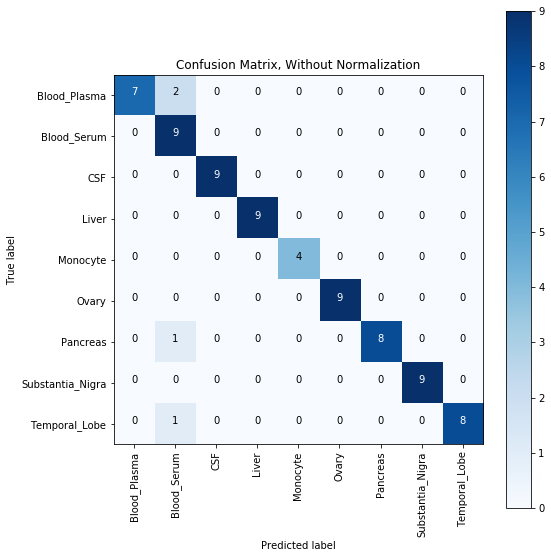

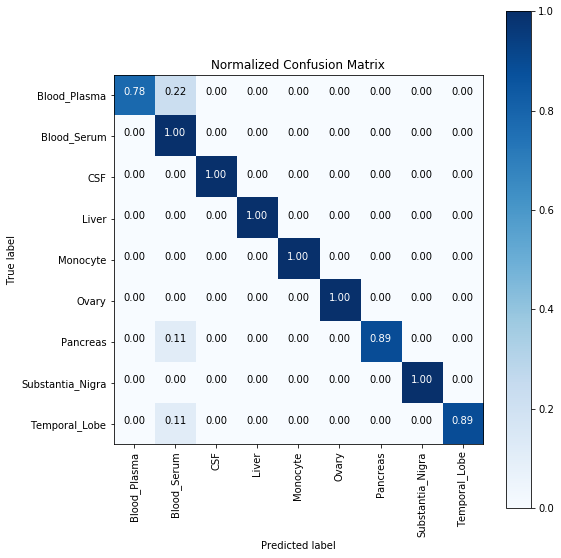

In [27]:
cu.show_confusion_matrices(test_labels, knn_pipe_pred, tissues)